In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from utils.stats import calculate_subgroup_metric_median_stats, friedman_with_posthoc
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from utils.stats import calculate_sensitivity, calculate_dice_mean

In [2]:
def plot_heatmap(corr_matrix, ax, idx_order, cmap='coolwarm', 
                           annot=True, fmt='.2f', title='Correlation Heatmap'):

    corr_matrix = corr_matrix.loc[idx_order, idx_order]
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
    

    # For binary data, use a discrete colormap and specific settings
    #cmap = 'RdYlBu_r'  # Better for binary data
    #fmt = '.0f'  # No decimals for binary values
    vmin, vmax = 0, 1
    # cbar_kws = {
    #     'shrink': 0.8,
    #     'ticks': [0, 1],
    #     'label': 'Significance (0=No, 1=Yes)'
    # }
    
    # Generate heatmap
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=annot, 
                fmt=fmt,
                cmap=cmap,
                center=0.5,
                square=True,
                vmin=vmin,
                vmax=vmax,
                cbar=False,
                annot_kws={'size': 14},
                #cbar_kws=cbar_kws,
                ax=ax)
    
    # Set title
    ax.set_title(title, fontsize=16, pad=20)
    ax.tick_params(axis='both', which='major', labelsize=14)  # Tick labels
    
    # Adjust layout
    plt.tight_layout()


### Classification

In [3]:
results_cla = pd.read_csv('./stats/4_1_cv_scores_cla_subgroup.csv')
results_cla

,logits,labels,probs,paths,freeze,model,task,target,fold,ImagePath,Volume,Volume Quartile,ChestTube,preds,results,Vol-Tube
0,1.573389,1.0,0.828266,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.4577.151787518...,0.311565,Q1,1,1,TP,Q1-1
1,2.737088,1.0,0.939180,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.1263.151787516...,2.875519,Q4,1,1,TP,Q4-1
2,1.259774,1.0,0.778987,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.5013.151787518...,1.105976,Q3,0,1,TP,Q3-0
3,-1.467685,1.0,0.187295,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.11175.15178752...,1.556301,Q3,0,0,FN,Q3-0
4,2.883493,1.0,0.947024,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,MedSigLIP,classification,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.2915.151787517...,9.354877,Q4,1,1,TP,Q4-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40438,2.412690,1.0,0.917790,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.13794.15178752...,5.300999,Q4,1,1,TP,Q4-1
40439,3.861110,1.0,0.979389,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.3967.151787518...,0.758076,Q2,1,1,TP,Q2-1
40440,2.968152,1.0,0.951114,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.10358.15178752...,0.070763,Q1,1,1,TP,Q1-1
40441,3.362121,1.0,0.966499,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,classification,pneumothorax,1,1.2.276.0.7230010.3.1.4.8323329.13159.15178752...,0.233173,Q1,1,1,TP,Q1-1


In [4]:
# Calculate metric for each subgroup
results_cla = results_cla.groupby(['fold', 'model', 'freeze', 'target','Vol-Tube']).apply(calculate_sensitivity)
results_cla = results_cla.reset_index(name='Sensitivity')

/tmp/ipykernel_402518/2620753188.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_cla = results_cla.groupby(['fold', 'model', 'freeze', 'target','Vol-Tube']).apply(calculate_sensitivity)


In [5]:
results_cla['freeze'] = results_cla.freeze.replace({1:'Linear Probing', 0:'Fine-tuning'})
results_cla.loc[results_cla.model == 'SegFormer', 'freeze'] = 'End-to-end'

In [6]:
results_cla

,fold,model,freeze,target,Vol-Tube,Sensitivity
0,0,Ark+,Fine-tuning,pneumothorax,Q1-0,0.625000
1,0,Ark+,Fine-tuning,pneumothorax,Q1-1,0.922222
2,0,Ark+,Fine-tuning,pneumothorax,Q2-0,0.939394
3,0,Ark+,Fine-tuning,pneumothorax,Q2-1,0.968421
4,0,Ark+,Fine-tuning,pneumothorax,Q3-0,0.933333
...,...,...,...,...,...,...
675,4,SigLIP2,Linear Probing,pneumothorax,Q2-1,0.911111
676,4,SigLIP2,Linear Probing,pneumothorax,Q3-0,0.558824
677,4,SigLIP2,Linear Probing,pneumothorax,Q3-1,0.939759
678,4,SigLIP2,Linear Probing,pneumothorax,Q4-0,0.655172


In [7]:
def stats_tests(results, g, t, f):
    results_sub = results[(results['Vol-Tube']==g) & (results.target==t) & ((results.freeze==f) | (results.freeze=='End-to-end'))]
    posthoc = friedman_with_posthoc(results_sub, block_col='fold', treatment_col='model', score_col='Sensitivity', alpha=0.05)
    return posthoc

Friedman Test statistic: 8.2998, p-value: 0.4047

Friedman test not significant (p >= 0.05). Nemenyi test not required.
Friedman Test statistic: 17.5667, p-value: 0.0247

Friedman test significant (p < 0.05). Performing Nemenyi post-hoc test...

Nemenyi Post-Hoc Test Results:
                      Ark+  BiomedCLIP  CheXagent    DINOv2  MedImageInsights  \
Ark+              1.000000    0.488170   0.528677  0.903592          0.999946   
BiomedCLIP        0.488170    1.000000   1.000000  0.998888          0.212625   
CheXagent         0.528677    1.000000   1.000000  0.999411          0.240303   
DINOv2            0.903592    0.998888   0.999411  1.000000          0.650119   
MedImageInsights  0.999946    0.212625   0.240303  0.650119          1.000000   
MedSigLIP         0.923232    0.998024   0.998888  1.000000          0.689139   
RAD-DINO          0.610079    1.000000   1.000000  0.999868          0.302184   
SegFormer         0.212625    0.999946   0.999868  0.965588          0.0667

/tmp/ipykernel_402518/465825734.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


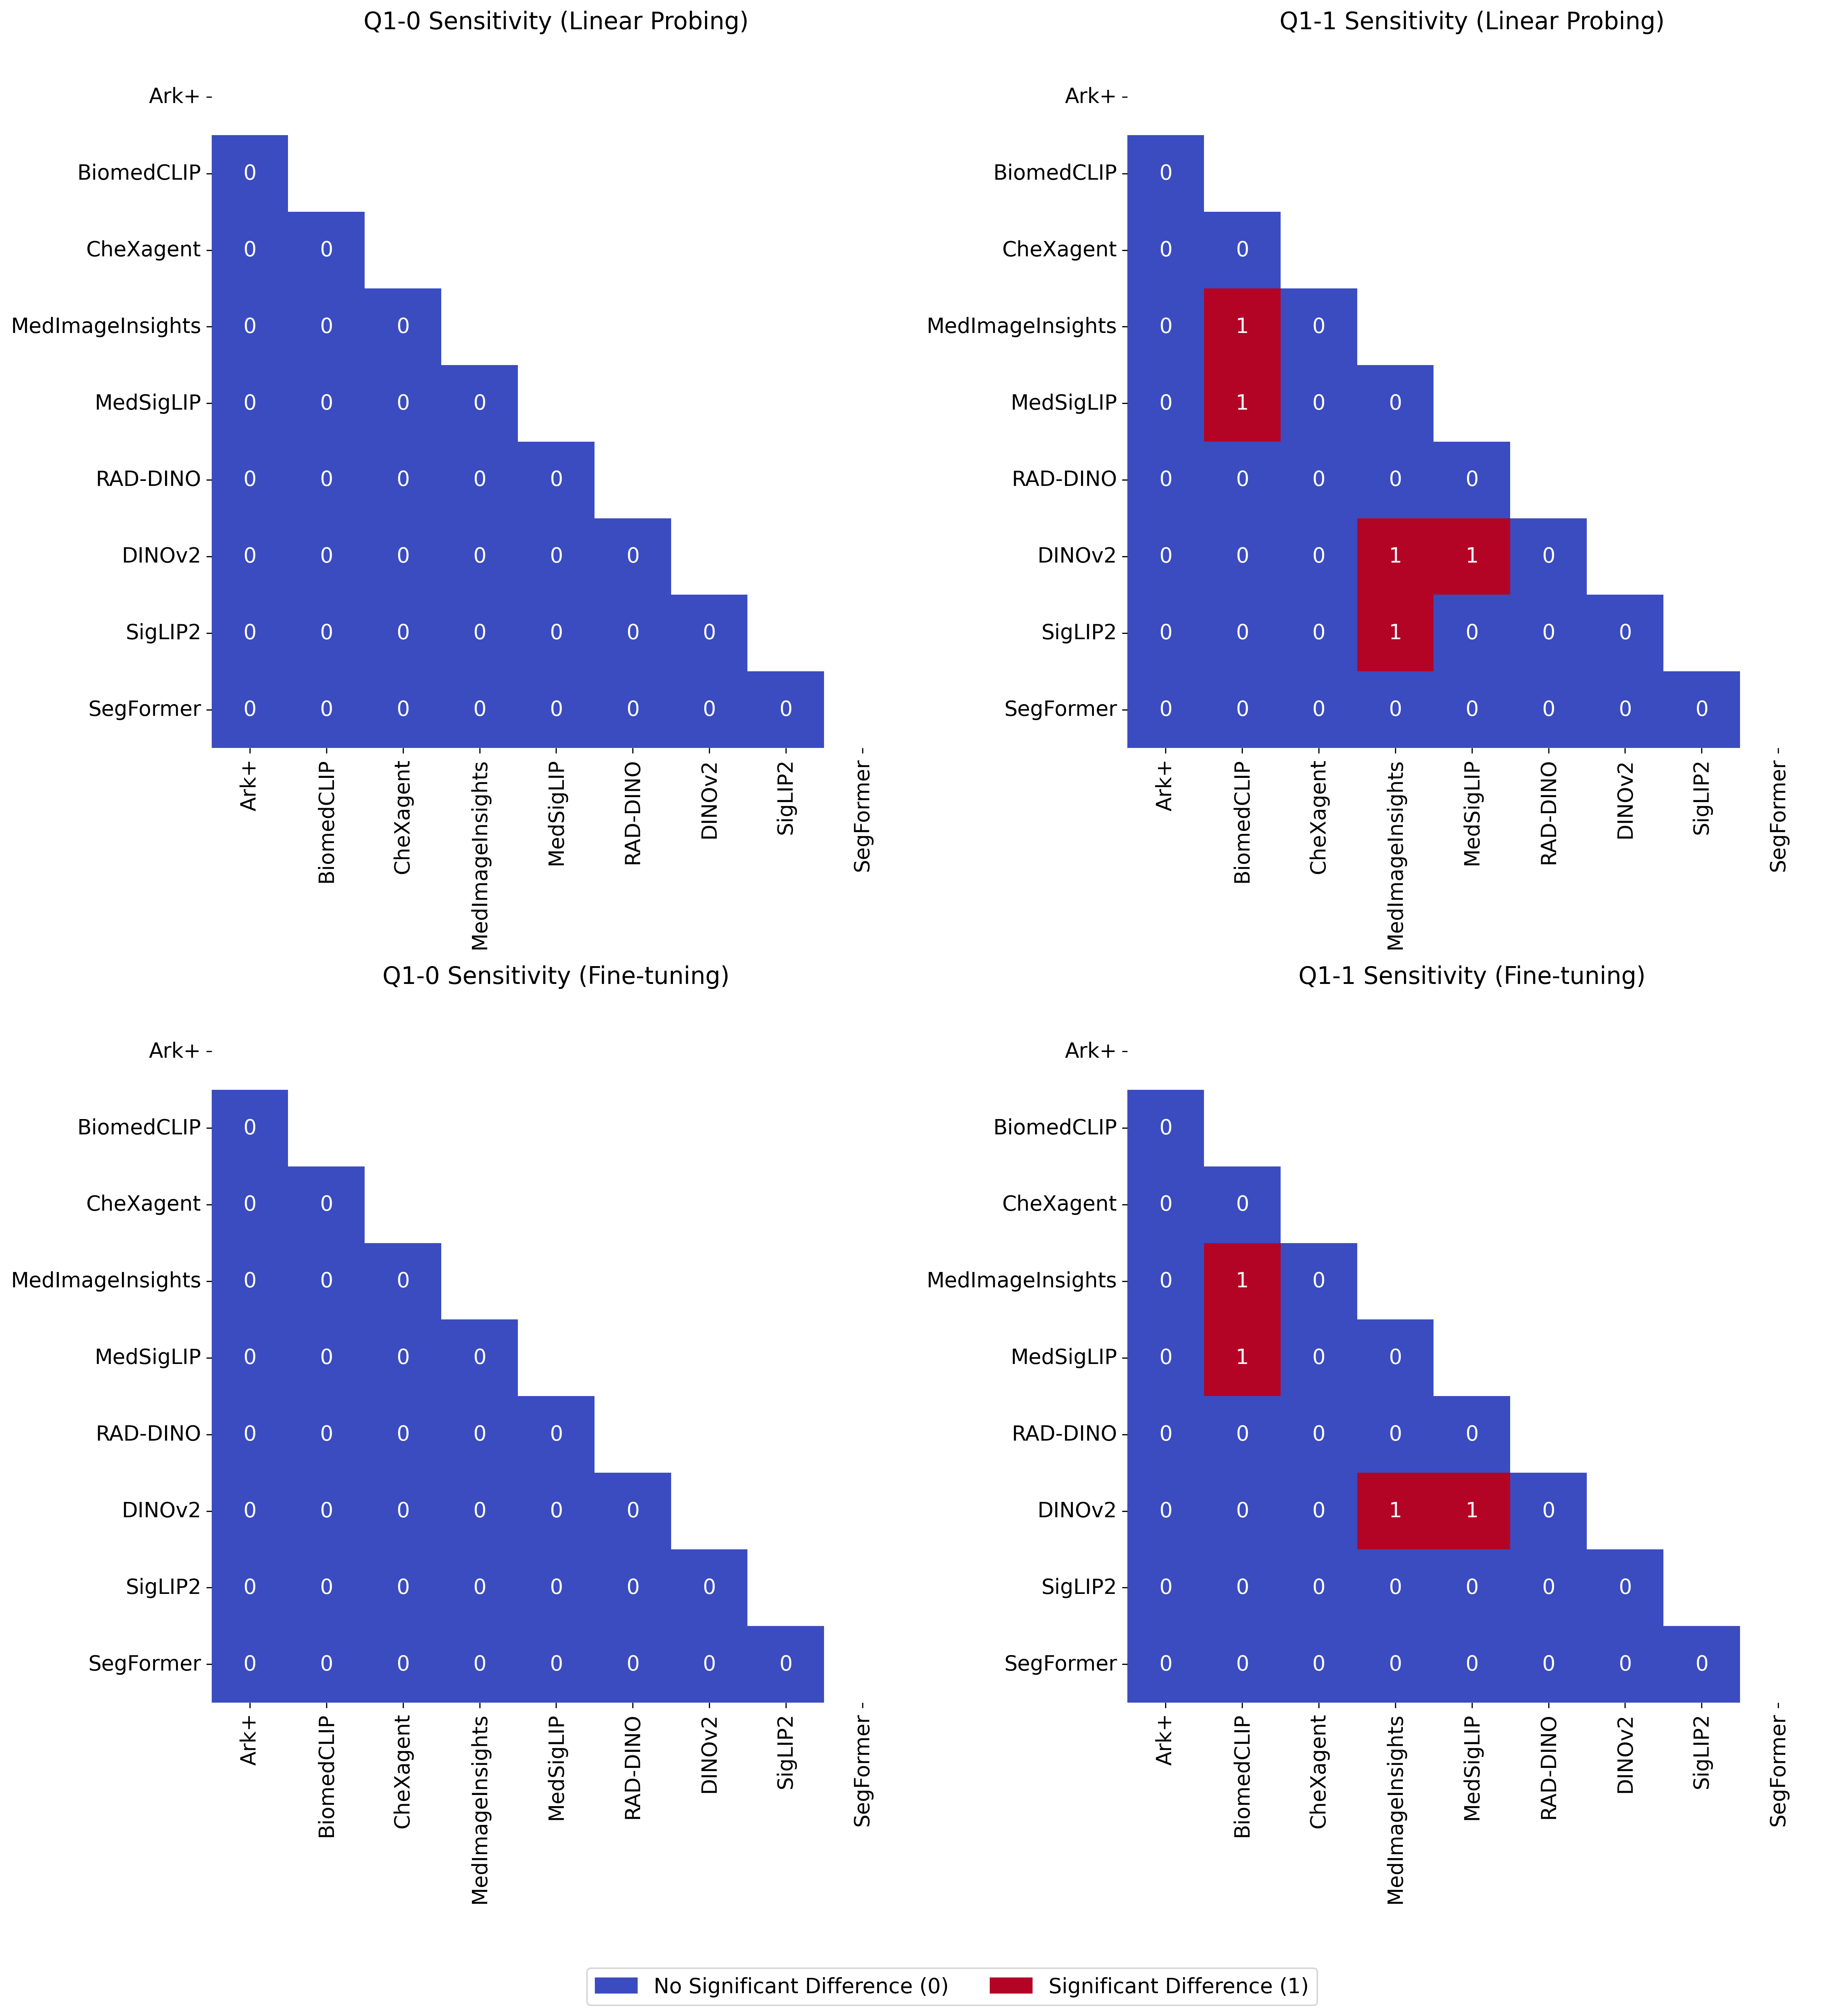

In [10]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 18), dpi=300)
idx_order = ['Ark+', 'BiomedCLIP', 'CheXagent', 'MedImageInsights', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']
zeros = pd.DataFrame(np.zeros((len(idx_order),len(idx_order))),index=idx_order, columns=idx_order)

posthoc_ptx_cla_fz_q1_0 = stats_tests(results_cla, 'Q1-0', 'pneumothorax', 'Linear Probing')
try:
    plot_heatmap(posthoc_ptx_cla_fz_q1_0['nemenyi_results']<0.05, axes[0,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-0 Sensitivity (Linear Probing)')
except:
    plot_heatmap(zeros, axes[0,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-0 Sensitivity (Linear Probing)')

posthoc_ptx_cla_e2e_q1_0 = stats_tests(results_cla, 'Q1-0', 'pneumothorax', 'Fine-tuning')
try:
    plot_heatmap(posthoc_ptx_cla_e2e_q1_0['nemenyi_results']<0.05, axes[1,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-0 Sensitivity (Fine-tuning)')
except:
    plot_heatmap(zeros, axes[1,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-0 Sensitivity (Fine-tuning)')

posthoc_ptx_cla_fz_q1_1 = stats_tests(results_cla, 'Q1-1', 'pneumothorax', 'Linear Probing')
try:
    plot_heatmap(posthoc_ptx_cla_fz_q1_1['nemenyi_results']<0.05, axes[0,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-1 Sensitivity (Linear Probing)')
except:
    plot_heatmap(zeros, axes[0,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-1 Sensitivity (Linear Probing)')

posthoc_ptx_cla_e2e_q1_1 = stats_tests(results_cla, 'Q1-1', 'pneumothorax', 'Fine-tuning')
try:
    plot_heatmap(posthoc_ptx_cla_e2e_q1_1['nemenyi_results']<0.05, axes[1,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-1 Sensitivity (Fine-tuning)')
except:
    plot_heatmap(zeros, axes[1,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-1 Sensitivity (Fine-tuning)')


# Get colors from colormap
cmap = cm.get_cmap('coolwarm')
color_0 = cmap(0.0)  # Color for value 0
color_1 = cmap(1.0)  # Color for value 1

# Create custom legend patches
no_sig_patch = mpatches.Patch(color=color_0, label='No Significant Difference (0)')
sig_patch = mpatches.Patch(color=color_1, label='Significant Difference (1)')

# Add legend
fig.legend(handles=[no_sig_patch, sig_patch], 
          loc='lower center', 
          bbox_to_anchor=(0.5, -0.05),
          ncol=2,
          fontsize=14,
          frameon=True,
          fancybox=True,
          shadow=False)

plt.tight_layout()
plt.show()

Friedman Test statistic: 8.2998, p-value: 0.4047

Friedman test not significant (p >= 0.05). Nemenyi test not required.
Friedman Test statistic: 17.5667, p-value: 0.0247

Friedman test significant (p < 0.05). Performing Nemenyi post-hoc test...

Nemenyi Post-Hoc Test Results:
                      Ark+  BiomedCLIP  CheXagent    DINOv2  MedImageInsights  \
Ark+              1.000000    0.488170   0.528677  0.903592          0.999946   
BiomedCLIP        0.488170    1.000000   1.000000  0.998888          0.212625   
CheXagent         0.528677    1.000000   1.000000  0.999411          0.240303   
DINOv2            0.903592    0.998888   0.999411  1.000000          0.650119   
MedImageInsights  0.999946    0.212625   0.240303  0.650119          1.000000   
MedSigLIP         0.923232    0.998024   0.998888  1.000000          0.689139   
RAD-DINO          0.610079    1.000000   1.000000  0.999868          0.302184   
SegFormer         0.212625    0.999946   0.999868  0.965588          0.0667

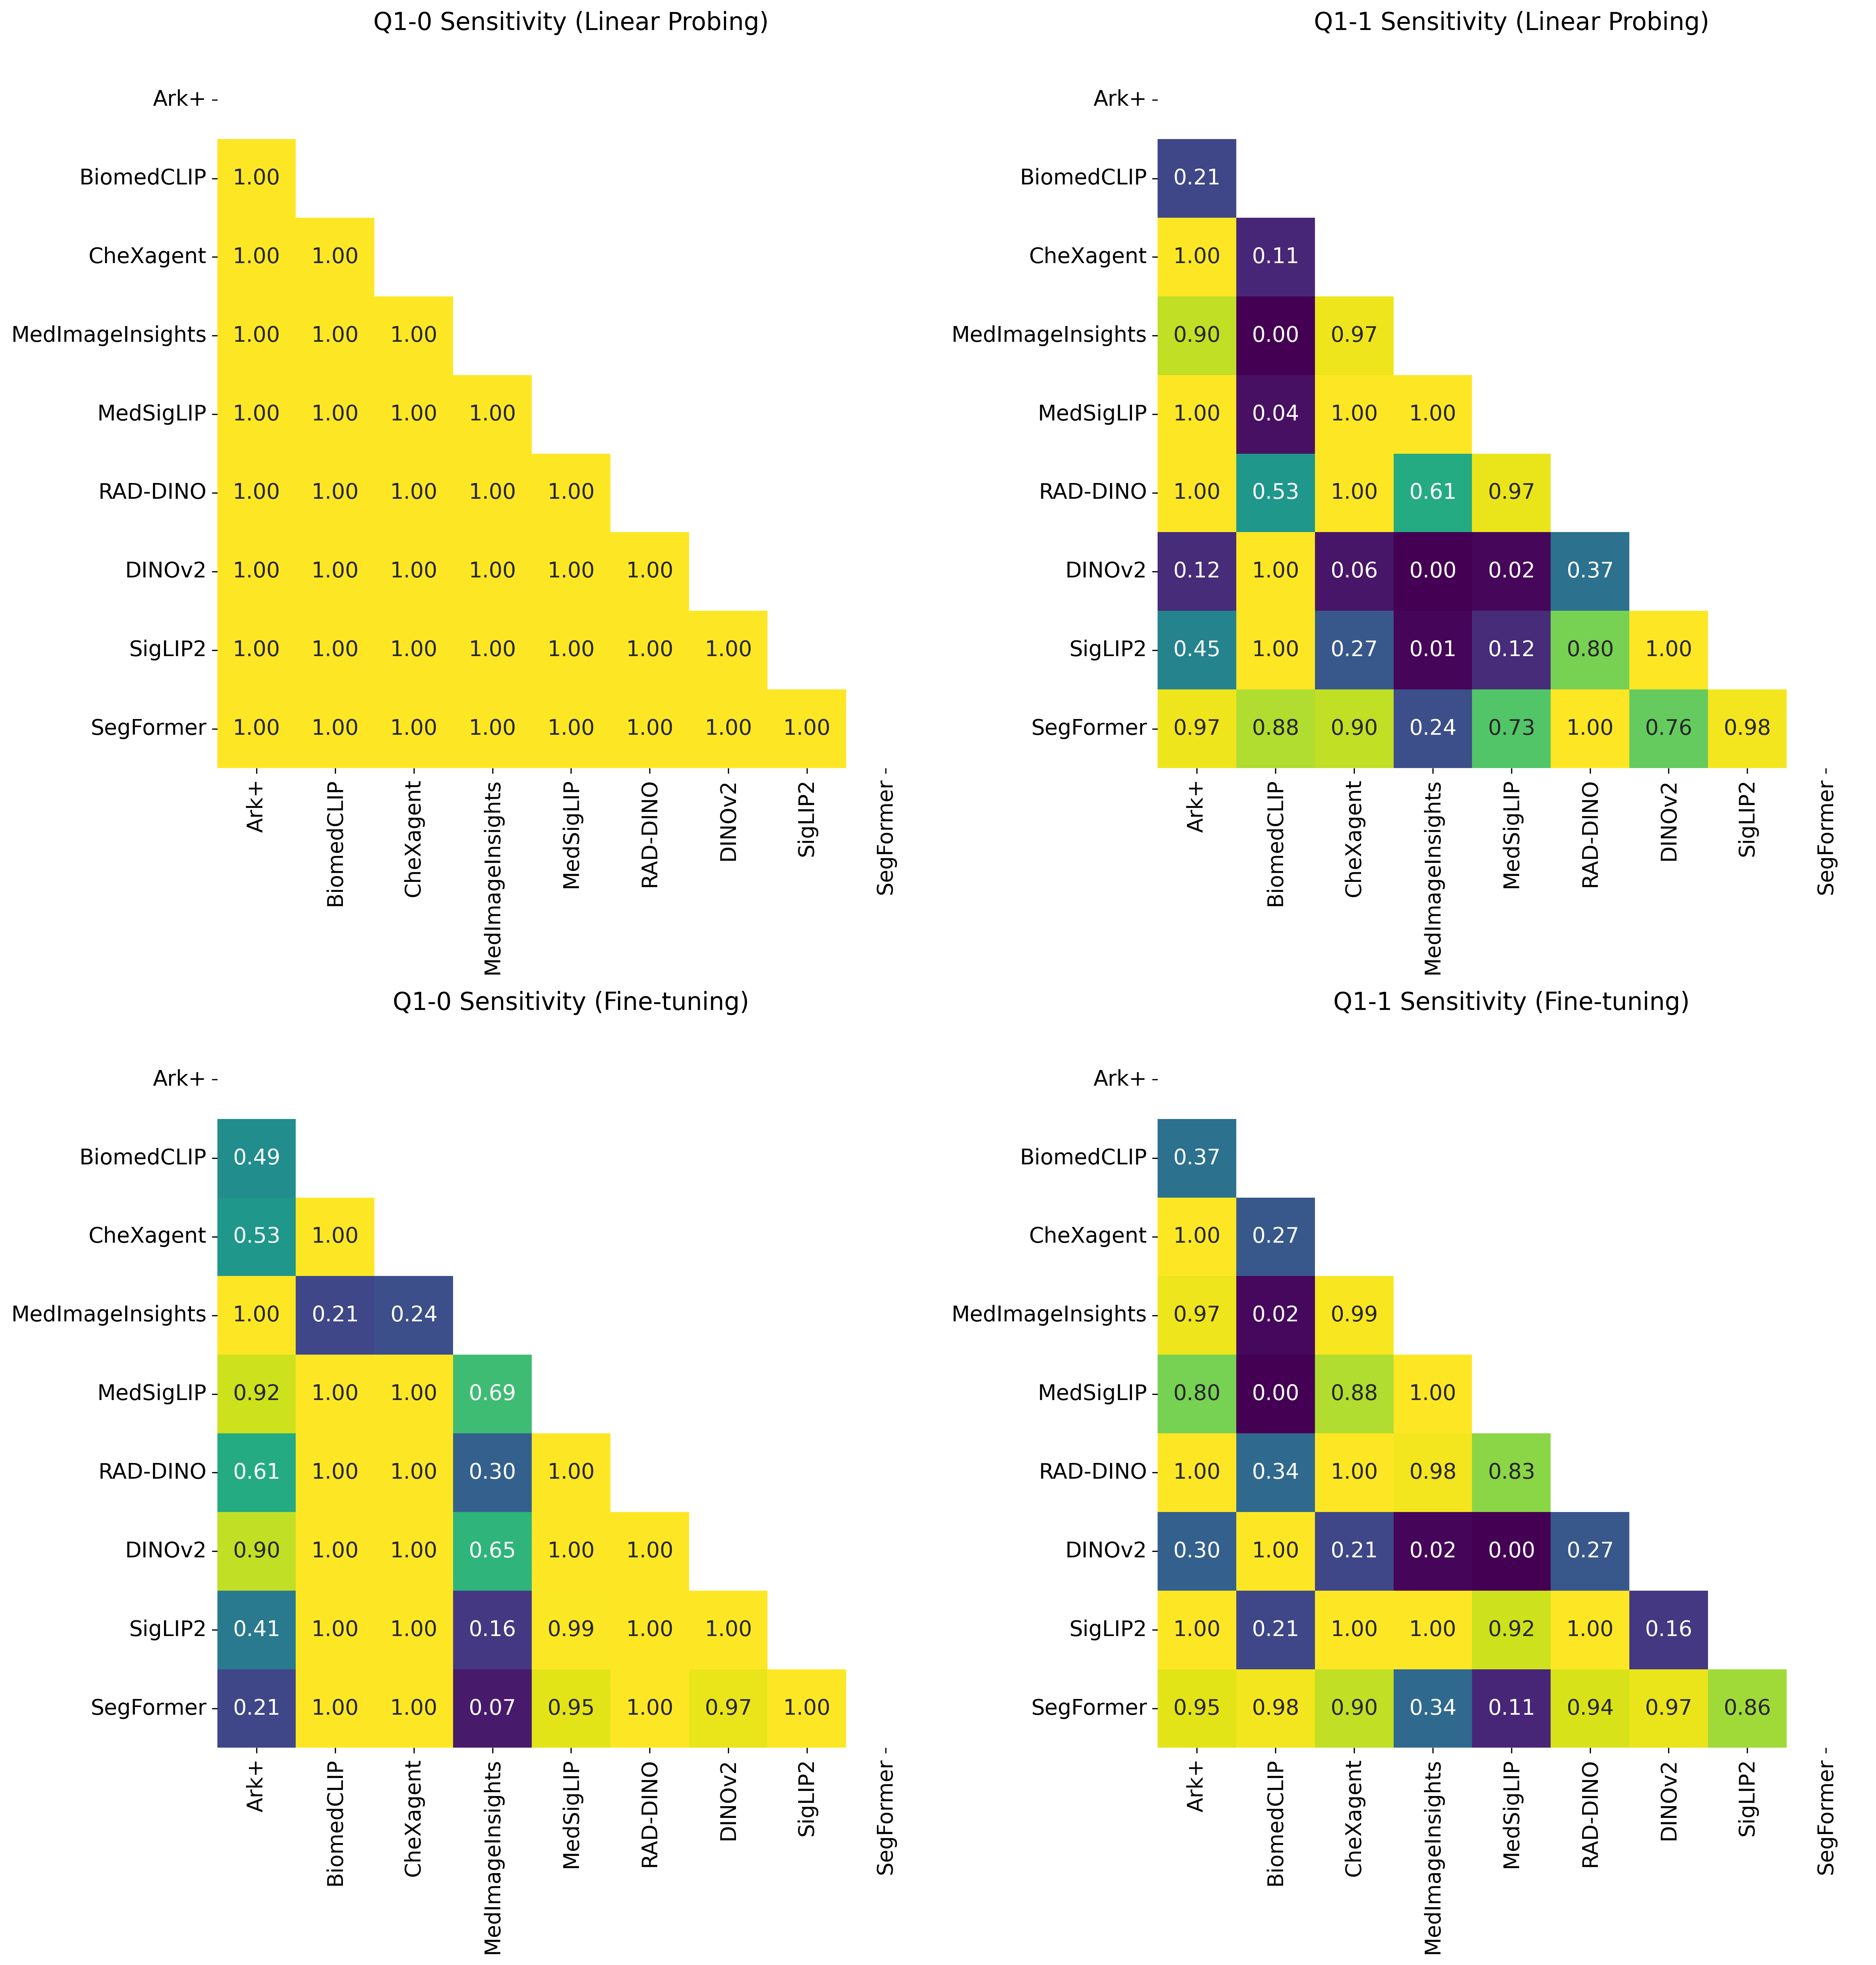

In [12]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 18), dpi=300)
idx_order = ['Ark+', 'BiomedCLIP', 'CheXagent', 'MedImageInsights', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']
ones = pd.DataFrame(np.ones((len(idx_order),len(idx_order))),index=idx_order, columns=idx_order)

posthoc_ptx_cla_fz_q1_0 = stats_tests(results_cla, 'Q1-0', 'pneumothorax', 'Linear Probing')
try:
    plot_heatmap(posthoc_ptx_cla_fz_q1_0['nemenyi_results'], axes[0,0], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-0 Sensitivity (Linear Probing)')
except:
    plot_heatmap(ones, axes[0,0], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-0 Sensitivity (Linear Probing)')

posthoc_ptx_cla_e2e_q1_0 = stats_tests(results_cla, 'Q1-0', 'pneumothorax', 'Fine-tuning')
try:
    plot_heatmap(posthoc_ptx_cla_e2e_q1_0['nemenyi_results'], axes[1,0], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-0 Sensitivity (Fine-tuning)')
except:
    plot_heatmap(ones, axes[1,0], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-0 Sensitivity (Fine-tuning)')

posthoc_ptx_cla_fz_q1_1 = stats_tests(results_cla, 'Q1-1', 'pneumothorax', 'Linear Probing')
try:
    plot_heatmap(posthoc_ptx_cla_fz_q1_1['nemenyi_results'], axes[0,1], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-1 Sensitivity (Linear Probing)')
except:
    plot_heatmap(ones, axes[0,1], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-1 Sensitivity (Linear Probing)')

posthoc_ptx_cla_e2e_q1_1 = stats_tests(results_cla, 'Q1-1', 'pneumothorax', 'Fine-tuning')
try:
    plot_heatmap(posthoc_ptx_cla_e2e_q1_1['nemenyi_results'], axes[1,1], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-1 Sensitivity (Fine-tuning)')
except:
    plot_heatmap(ones, axes[1,1], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-1 Sensitivity (Fine-tuning)')


plt.tight_layout()
plt.show()

In [9]:
# # Create subplots
# fig, axes = plt.subplots(2, 2, figsize=(18, 18), dpi=300)
# idx_order = ['Ark+', 'BiomedCLIP', 'CheXagent', 'MedImageInsights', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']
# zeros = pd.DataFrame(np.zeros((len(idx_order),len(idx_order))),index=idx_order, columns=idx_order)

# posthoc_ptx_cla_fz_q4_0 = stats_tests(results_cla, 'Q4-0', 'pneumothorax', 'Linear Probing')
# try:
#     plot_heatmap(posthoc_ptx_cla_fz_q4_0['nemenyi_results']<0.1, axes[0,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-0 Sensitivity (Linear Probing)')
# except:
#     plot_heatmap(zeros, axes[0,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-0 Sensitivity (Linear Probing)')

# posthoc_ptx_cla_e2e_q4_0 = stats_tests(results_cla, 'Q4-0', 'pneumothorax', 'Fine-tuning')
# try:
#     plot_heatmap(posthoc_ptx_cla_e2e_q4_0['nemenyi_results']<0.1, axes[1,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-0 Sensitivity (Fine-tuning)')
# except:
#     plot_heatmap(zeros, axes[1,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-0 Sensitivity (Fine-tuning)')

# posthoc_ptx_cla_fz_q4_1 = stats_tests(results_cla, 'Q4-1', 'pneumothorax', 'Linear Probing')
# try:
#     plot_heatmap(posthoc_ptx_cla_fz_q4_1['nemenyi_results']<0.1, axes[0,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-1 Sensitivity (Linear Probing)')
# except:
#     plot_heatmap(zeros, axes[0,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-1 Sensitivity (Linear Probing)')

# posthoc_ptx_cla_e2e_q4_1 = stats_tests(results_cla, 'Q4-1', 'pneumothorax', 'Fine-tuning')
# try:
#     plot_heatmap(posthoc_ptx_cla_e2e_q4_1['nemenyi_results']<0.1, axes[1,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-1 Sensitivity (Fine-tuning)')
# except:
#     plot_heatmap(zeros, axes[1,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-1 Sensitivity (Fine-tuning)')


# # Get colors from colormap
# cmap = cm.get_cmap('coolwarm')
# color_0 = cmap(0.0)  # Color for value 0
# color_1 = cmap(1.0)  # Color for value 1

# # Create custom legend patches
# no_sig_patch = mpatches.Patch(color=color_0, label='No Significant Difference (0)')
# sig_patch = mpatches.Patch(color=color_1, label='Significant Difference (1)')

# # Add legend
# fig.legend(handles=[no_sig_patch, sig_patch], 
#           loc='lower center', 
#           bbox_to_anchor=(0.5, -0.05),
#           ncol=2,
#           fontsize=14,
#           frameon=True,
#           fancybox=True,
#           shadow=False)

# plt.tight_layout()
# plt.show()

### Segmentation

In [54]:
def stats_tests(results, g, t, f):
    results_sub = results[(results['Vol-Tube']==g) & (results.target==t) & ((results.freeze==f) | (results.freeze=='End-to-end'))]
    posthoc = friedman_with_posthoc(results_sub, block_col='fold', treatment_col='model', score_col='dice', alpha=0.05)
    return posthoc

In [55]:
results_seg = pd.read_csv('./stats/4_2_cv_scores_seg_subgroup.csv')
results_seg

,iou,dice,paths,freeze,model,task,target,fold,ImagePath,Volume,Volume Quartile,ChestTube,Vol-Tube
0,0.472557,0.641818,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,BiomedCLIP,segmentation,pneumothorax,0,1.2.276.0.7230010.3.1.4.8323329.2421.151787517...,0.753021,Q2,0,Q2-0
1,0.058714,0.110915,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,BiomedCLIP,segmentation,pneumothorax,0,1.2.276.0.7230010.3.1.4.8323329.31802.15178751...,5.468082,Q4,1,Q4-1
2,0.254786,0.406103,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,BiomedCLIP,segmentation,pneumothorax,0,1.2.276.0.7230010.3.1.4.8323329.14213.15178752...,1.470089,Q3,0,Q3-0
3,0.214689,0.353488,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,BiomedCLIP,segmentation,pneumothorax,0,1.2.276.0.7230010.3.1.4.8323329.5614.151787518...,1.035976,Q3,1,Q3-1
4,0.229028,0.372698,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,1,BiomedCLIP,segmentation,pneumothorax,0,1.2.276.0.7230010.3.1.4.8323329.13422.15178752...,0.680161,Q2,0,Q2-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49954,0.454806,0.625246,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,segmentation,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.10318.15178752...,2.824593,Q4,1,Q4-1
49955,0.622922,0.767655,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,segmentation,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.32609.15178751...,1.000118,Q3,1,Q3-1
49956,0.567037,0.723706,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,segmentation,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.512.1517875163...,0.938797,Q3,1,Q3-1
49957,0.000259,0.000517,/mnt/NAS3/datasets/external/SIIM_ACR_Pneumotho...,0,SegFormer,segmentation,pneumothorax,4,1.2.276.0.7230010.3.1.4.8323329.12402.15178752...,0.380707,Q2,1,Q2-1


In [56]:
# Calculate metric for each subgroup
results_seg = results_seg.groupby(['fold', 'model', 'freeze', 'target','Vol-Tube']).apply(calculate_dice_mean)
results_seg = results_seg.reset_index(name='dice')

/tmp/ipykernel_402518/263176801.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_seg = results_seg.groupby(['fold', 'model', 'freeze', 'target','Vol-Tube']).apply(calculate_dice_mean)


In [57]:
results_seg['freeze'] = results_seg.freeze.replace({1:'Linear Probing', 0:'Fine-tuning'})
results_seg.loc[results_seg.model == 'SegFormer', 'freeze'] = 'End-to-end'

Friedman Test statistic: 44.7273, p-value: 0.0000

Friedman test significant (p < 0.05). Performing Nemenyi post-hoc test...

Nemenyi Post-Hoc Test Results:
                      Ark+(16)  Ark+(32)  BiomedCLIP  CheXagent    DINOv2  \
Ark+(16)              1.000000  0.911607    0.003031   0.997179  0.062093   
Ark+(32)              0.911607  1.000000    0.316814   0.999970  0.873804   
BiomedCLIP            0.003031  0.316814    1.000000   0.081707  0.998844   
CheXagent             0.997179  0.999970    0.081707   1.000000  0.509800   
DINOv2                0.062093  0.873804    0.998844   0.509800  1.000000   
MedImageInsights(16)  0.999877  0.998844    0.034500   1.000000  0.316814   
MedImageInsights(32)  0.046578  0.827606    0.999588   0.441886  1.000000   
MedSigLIP             0.579005  0.999970    0.712979   0.987891  0.993865   
RAD-DINO              0.999999  0.987891    0.013033   0.999970  0.171630   
SegFormer             0.999877  0.509800    0.000157   0.873804  0.006425

/tmp/ipykernel_402518/2930540759.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


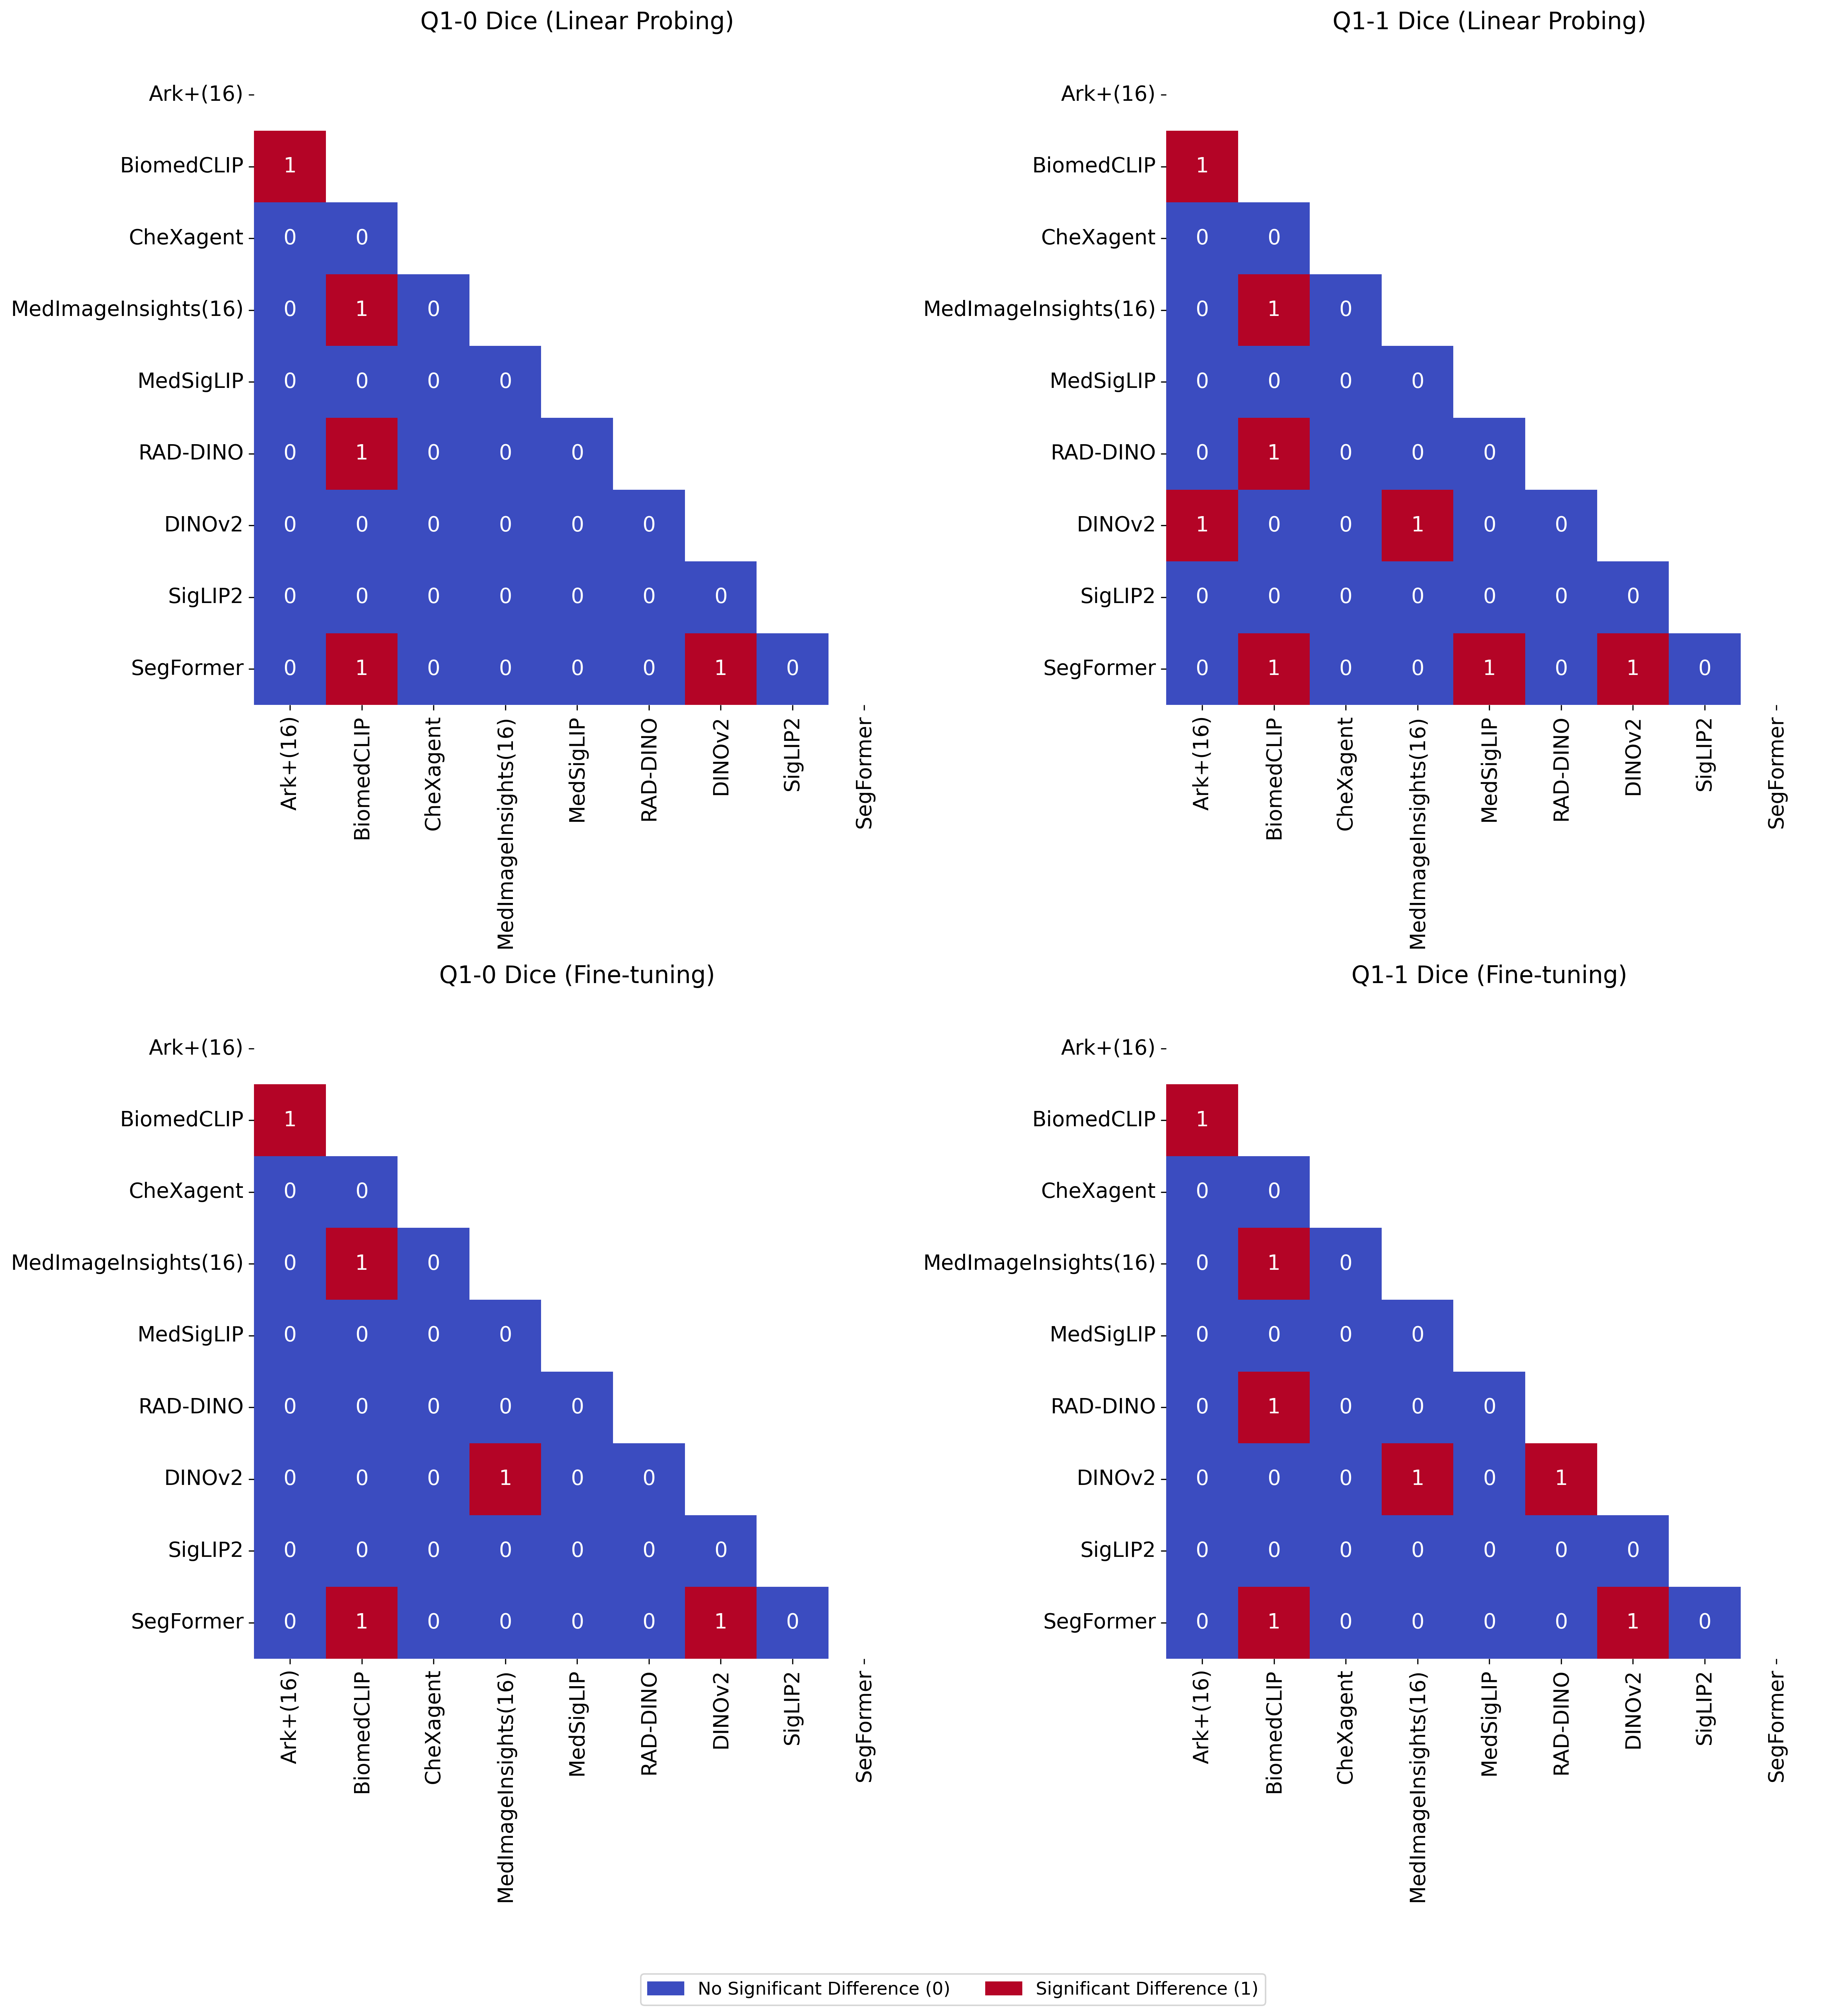

In [58]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 18), dpi=300)
idx_order = ['Ark+(16)', 'BiomedCLIP', 'CheXagent', 'MedImageInsights(16)', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']
zeros = pd.DataFrame(np.zeros((len(idx_order),len(idx_order))),index=idx_order, columns=idx_order)

posthoc_ptx_seg_fz_q1_0 = stats_tests(results_seg, 'Q1-0', 'pneumothorax', 'Linear Probing')
try:
    plot_heatmap(posthoc_ptx_seg_fz_q1_0['nemenyi_results']<0.05, axes[0,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-0 Dice (Linear Probing)')
except:
    plot_heatmap(zeros, axes[0,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-0 Dice (Linear Probing)')

posthoc_ptx_seg_e2e_q1_0 = stats_tests(results_seg, 'Q1-0', 'pneumothorax', 'Fine-tuning')
try:
    plot_heatmap(posthoc_ptx_seg_e2e_q1_0['nemenyi_results']<0.05, axes[1,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-0 Dice (Fine-tuning)')
except:
    plot_heatmap(zeros, axes[1,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-0 Dice (Fine-tuning)')

posthoc_ptx_seg_fz_q1_1 = stats_tests(results_seg, 'Q1-1', 'pneumothorax', 'Linear Probing')
try:
    plot_heatmap(posthoc_ptx_seg_fz_q1_1['nemenyi_results']<0.05, axes[0,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-1 Dice (Linear Probing)')
except:
    plot_heatmap(zeros, axes[0,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-1 Dice (Linear Probing)')

posthoc_ptx_seg_e2e_q1_1 = stats_tests(results_seg, 'Q1-1', 'pneumothorax', 'Fine-tuning')
try:
    plot_heatmap(posthoc_ptx_seg_e2e_q1_1['nemenyi_results']<0.05, axes[1,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-1 Dice (Fine-tuning)')
except:
    plot_heatmap(zeros, axes[1,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q1-1 Dice (Fine-tuning)')

# Get colors from your colormap
cmap = cm.get_cmap('coolwarm')
color_0 = cmap(0.0)  # Color for value 0
color_1 = cmap(1.0)  # Color for value 1

# Create custom legend patches
no_sig_patch = mpatches.Patch(color=color_0, label='No Significant Difference (0)')
sig_patch = mpatches.Patch(color=color_1, label='Significant Difference (1)')

# Add legend
fig.legend(handles=[no_sig_patch, sig_patch], 
          loc='lower center', 
          bbox_to_anchor=(0.5, -0.05),
          ncol=2,
          fontsize=12,
          frameon=True,
          fancybox=True,
          shadow=False)

plt.tight_layout()
plt.show()


Friedman Test statistic: 44.7273, p-value: 0.0000

Friedman test significant (p < 0.05). Performing Nemenyi post-hoc test...

Nemenyi Post-Hoc Test Results:
                      Ark+(16)  Ark+(32)  BiomedCLIP  CheXagent    DINOv2  \
Ark+(16)              1.000000  0.911607    0.003031   0.997179  0.062093   
Ark+(32)              0.911607  1.000000    0.316814   0.999970  0.873804   
BiomedCLIP            0.003031  0.316814    1.000000   0.081707  0.998844   
CheXagent             0.997179  0.999970    0.081707   1.000000  0.509800   
DINOv2                0.062093  0.873804    0.998844   0.509800  1.000000   
MedImageInsights(16)  0.999877  0.998844    0.034500   1.000000  0.316814   
MedImageInsights(32)  0.046578  0.827606    0.999588   0.441886  1.000000   
MedSigLIP             0.579005  0.999970    0.712979   0.987891  0.993865   
RAD-DINO              0.999999  0.987891    0.013033   0.999970  0.171630   
SegFormer             0.999877  0.509800    0.000157   0.873804  0.006425

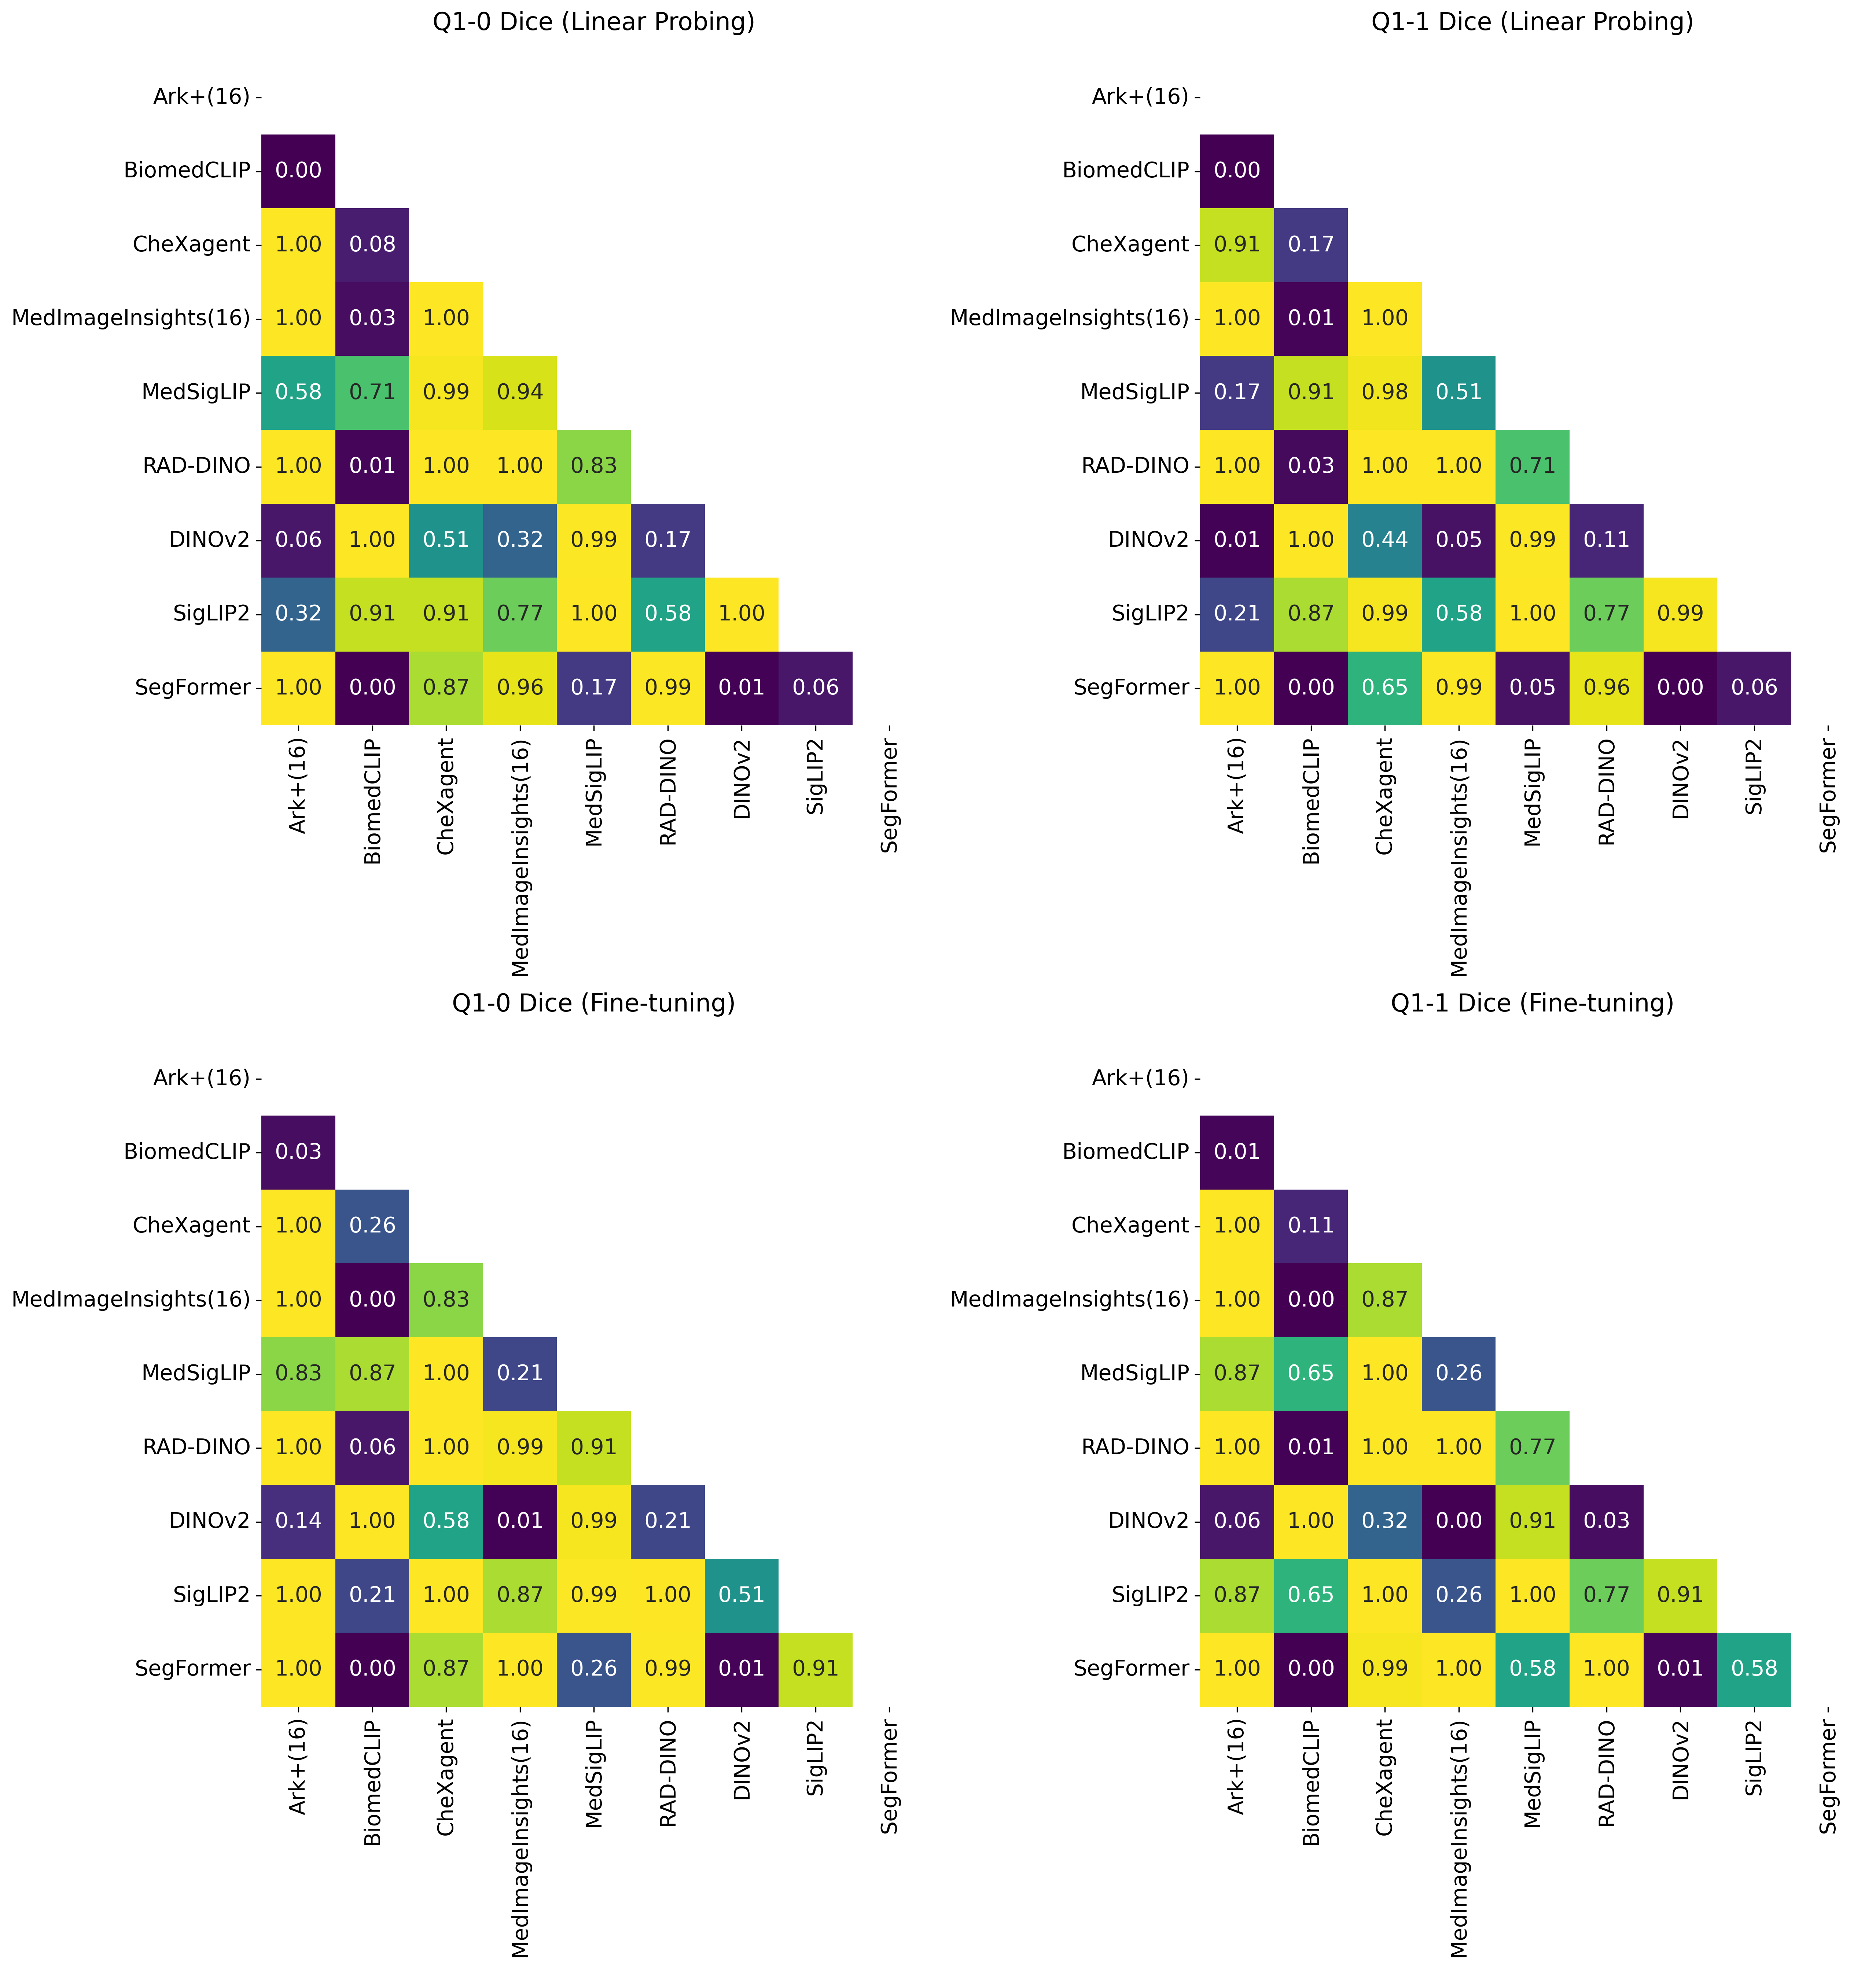

In [20]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 18), dpi=300)
idx_order = ['Ark+(16)', 'BiomedCLIP', 'CheXagent', 'MedImageInsights(16)', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']
ones = pd.DataFrame(np.ones((len(idx_order),len(idx_order))),index=idx_order, columns=idx_order)

posthoc_ptx_seg_fz_q1_0 = stats_tests(results_seg, 'Q1-0', 'pneumothorax', 'Linear Probing')
try:
    plot_heatmap(posthoc_ptx_seg_fz_q1_0['nemenyi_results'], axes[0,0], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-0 Dice (Linear Probing)')
except:
    plot_heatmap(ones, axes[0,0], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-0 Dice (Linear Probing)')

posthoc_ptx_seg_e2e_q1_0 = stats_tests(results_seg, 'Q1-0', 'pneumothorax', 'Fine-tuning')
try:
    plot_heatmap(posthoc_ptx_seg_e2e_q1_0['nemenyi_results'], axes[1,0], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-0 Dice (Fine-tuning)')
except:
    plot_heatmap(ones, axes[1,0], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-0 Dice (Fine-tuning)')

posthoc_ptx_seg_fz_q1_1 = stats_tests(results_seg, 'Q1-1', 'pneumothorax', 'Linear Probing')
try:
    plot_heatmap(posthoc_ptx_seg_fz_q1_1['nemenyi_results'], axes[0,1], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-1 Dice (Linear Probing)')
except:
    plot_heatmap(ones, axes[0,1], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-1 Dice (Linear Probing)')

posthoc_ptx_seg_e2e_q1_1 = stats_tests(results_seg, 'Q1-1', 'pneumothorax', 'Fine-tuning')
try:
    plot_heatmap(posthoc_ptx_seg_e2e_q1_1['nemenyi_results'], axes[1,1], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-1 Dice (Fine-tuning)')
except:
    plot_heatmap(ones, axes[1,1], idx_order, cmap='viridis', annot=True, fmt='.2f', title='Q1-1 Dice (Fine-tuning)')

plt.tight_layout()
plt.show()


In [19]:
# # Create subplots
# fig, axes = plt.subplots(2, 2, figsize=(18, 18), dpi=300)
# idx_order = ['Ark+(16)', 'BiomedCLIP', 'CheXagent', 'MedImageInsights(16)', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2', 'SegFormer']
# zeros = pd.DataFrame(np.zeros((len(idx_order),len(idx_order))),index=idx_order, columns=idx_order)

# posthoc_ptx_seg_fz_q4_0 = stats_tests(results_seg, 'Q4-0', 'pneumothorax', 'Linear Probing')
# try:
#     plot_heatmap(posthoc_ptx_seg_fz_q4_0['nemenyi_results']<0.05, axes[0,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-0 Dice (Linear Probing)')
# except:
#     plot_heatmap(zeros, axes[0,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-0 Dice (Linear Probing)')

# posthoc_ptx_seg_e2e_q4_0 = stats_tests(results_seg, 'Q4-0', 'pneumothorax', 'Fine-tuning')
# try:
#     plot_heatmap(posthoc_ptx_seg_e2e_q4_0['nemenyi_results']<0.05, axes[1,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-0 Dice (Fine-tuning)')
# except:
#     plot_heatmap(zeros, axes[1,0], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-0 Dice (Fine-tuning)')

# posthoc_ptx_seg_fz_q4_1 = stats_tests(results_seg, 'Q4-1', 'pneumothorax', 'Linear Probing')
# try:
#     plot_heatmap(posthoc_ptx_seg_fz_q4_1['nemenyi_results']<0.05, axes[0,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-1 Dice (Linear Probing)')
# except:
#     plot_heatmap(zeros, axes[0,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-1 Dice (Linear Probing)')

# posthoc_ptx_seg_e2e_q4_1 = stats_tests(results_seg, 'Q4-1', 'pneumothorax', 'Fine-tuning')
# try:
#     plot_heatmap(posthoc_ptx_seg_e2e_q4_1['nemenyi_results']<0.05, axes[1,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-1 Dice (Fine-tuning)')
# except:
#     plot_heatmap(zeros, axes[1,1], idx_order, cmap='coolwarm', annot=True, fmt='.0f', title='Q4-1 Dice (Fine-tuning)')

# # Get colors from your colormap
# cmap = cm.get_cmap('coolwarm')
# color_0 = cmap(0.0)  # Color for value 0
# color_1 = cmap(1.0)  # Color for value 1

# # Create custom legend patches
# no_sig_patch = mpatches.Patch(color=color_0, label='No Significant Difference (0)')
# sig_patch = mpatches.Patch(color=color_1, label='Significant Difference (1)')

# # Add legend
# fig.legend(handles=[no_sig_patch, sig_patch], 
#           loc='lower center', 
#           bbox_to_anchor=(0.5, -0.05),
#           ncol=2,
#           fontsize=12,
#           frameon=True,
#           fancybox=True,
#           shadow=False)

# plt.tight_layout()
# plt.show()


### effect of fine tuning

In [21]:
import pingouin as pg

def stats_tests2(results, g, t, M):
    results_sub = results[(results['Vol-Tube']==g) & (results.target==t) & (results.model==M)]
    # x = results_sub[results_sub.freeze=='Linear Probing'].loc[:,'dice']
    # y = results_sub[results_sub.freeze=='Fine-tuning'].loc[:,'dice']
    comp = pg.friedman(data=results_sub, dv="dice", within="freeze", subject="fold") # pg.wilcoxon(x, y, alternative='two-sided')
    comp.index = [M]
    comp['Vol-Tube'] = g
    return comp

#### segmentation

In [22]:
models = ['Ark+(16)', 'BiomedCLIP', 'CheXagent', 'MedImageInsights(16)', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2']
groups = ['Q1-0','Q1-1']#,'Q4-0','Q4-1']

paired_test_results = []
for g in groups:
    for M in models:    
        comp = stats_tests2(results_seg, g, 'pneumothorax', M)
        paired_test_results.append(comp)

In [23]:
stats_finetune = pd.concat(paired_test_results, axis=0)
stats_finetune = stats_finetune.reset_index(names=['model'])

seg_avg_ci = pd.read_csv('./stats/4_2_dice_comparison_seg_subgroup.csv')
seg_avg_ci = seg_avg_ci.merge(stats_finetune[['model','p-unc','Vol-Tube']], on=['model','Vol-Tube'], how='inner')
seg_avg_ci['Significance'] = seg_avg_ci['p-unc']<0.05
seg_avg_ci

,model,Vol-Tube,Dice_LinearProbing,Dice_Fine-tuning,p-unc,Significance
0,Ark+(16),Q1-0,0.276 (0.153-0.307),0.279 (0.158-0.312),0.025347,True
1,Ark+(16),Q1-1,0.226 (0.224-0.247),0.247 (0.228-0.259),0.025347,True
2,BiomedCLIP,Q1-0,0.067 (0.058-0.090),0.115 (0.093-0.119),0.025347,True
3,BiomedCLIP,Q1-1,0.080 (0.077-0.088),0.100 (0.086-0.104),0.025347,True
4,CheXagent,Q1-0,0.220 (0.188-0.262),0.240 (0.228-0.278),0.025347,True
5,CheXagent,Q1-1,0.187 (0.182-0.208),0.224 (0.214-0.232),0.025347,True
6,DINOv2,Q1-0,0.128 (0.086-0.145),0.138 (0.117-0.176),0.025347,True
7,DINOv2,Q1-1,0.091 (0.088-0.094),0.134 (0.127-0.146),0.025347,True
8,MedImageInsights(16),Q1-0,0.219 (0.198-0.260),0.292 (0.256-0.333),0.025347,True
9,MedImageInsights(16),Q1-1,0.212 (0.195-0.234),0.259 (0.250-0.283),0.025347,True


In [24]:
seg_avg_ci.to_csv('./stats/5_1_segmentation_finetuning_subgroup.csv', index=False)

#### classification

In [25]:
def stats_tests3(results, g, t, M):
    results_sub = results[(results['Vol-Tube']==g) & (results.target==t) & (results.model==M)]
    # x = results_sub[results_sub.freeze=='Linear Probing'].loc[:,'dice']
    # y = results_sub[results_sub.freeze=='Fine-tuning'].loc[:,'dice']
    comp = pg.friedman(data=results_sub, dv="Sensitivity", within="freeze", subject="fold") # pg.wilcoxon(x, y, alternative='two-sided')
    comp.index = [M]
    comp['Vol-Tube'] = g
    return comp

In [26]:
results_cla

,fold,model,freeze,target,Vol-Tube,Sensitivity
0,0,Ark+,Fine-tuning,pneumothorax,Q1-0,0.625000
1,0,Ark+,Fine-tuning,pneumothorax,Q1-1,0.922222
2,0,Ark+,Fine-tuning,pneumothorax,Q2-0,0.939394
3,0,Ark+,Fine-tuning,pneumothorax,Q2-1,0.968421
4,0,Ark+,Fine-tuning,pneumothorax,Q3-0,0.933333
...,...,...,...,...,...,...
675,4,SigLIP2,Linear Probing,pneumothorax,Q2-1,0.911111
676,4,SigLIP2,Linear Probing,pneumothorax,Q3-0,0.558824
677,4,SigLIP2,Linear Probing,pneumothorax,Q3-1,0.939759
678,4,SigLIP2,Linear Probing,pneumothorax,Q4-0,0.655172


In [27]:
models = ['Ark+', 'BiomedCLIP', 'CheXagent', 'MedImageInsights', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2']
groups = ['Q1-0','Q1-1']#,'Q4-0','Q4-1']

paired_test_results = []

for g in groups:
    for M in models:
        comp = stats_tests3(results_cla, g, 'pneumothorax', M)
        paired_test_results.append(comp)

In [28]:
stats_finetune = pd.concat(paired_test_results, axis=0)
stats_finetune = stats_finetune.reset_index(names=['model'])
stats_finetune = stats_finetune.rename(columns={'target':'Condition'})

cla_avg_ci = pd.read_csv('./stats/4_1_sensitivity_comparison_cla_subgroup.csv')
cla_avg_ci = cla_avg_ci.merge(stats_finetune[['model','p-unc','Vol-Tube']], on=['model','Vol-Tube'], how='inner')
cla_avg_ci['Significance'] = cla_avg_ci['p-unc']<0.05
cla_avg_ci

,model,Vol-Tube,Sensitivity_LinearProbing,Sensitivity_Fine-tuning,p-unc,Significance
0,Ark+,Q1-0,0.483 (0.357-0.600),0.586 (0.536-0.720),0.025347,True
1,Ark+,Q1-1,0.939 (0.911-0.952),0.922 (0.902-0.964),0.654721,False
2,BiomedCLIP,Q1-0,0.500 (0.375-0.607),0.469 (0.379-0.571),0.654721,False
3,BiomedCLIP,Q1-1,0.837 (0.800-0.881),0.859 (0.811-0.870),0.563703,False
4,CheXagent,Q1-0,0.520 (0.321-0.583),0.448 (0.333-0.625),0.179712,False
5,CheXagent,Q1-1,0.933 (0.909-0.967),0.933 (0.909-0.967),0.157299,False
6,DINOv2,Q1-0,0.583 (0.483-0.640),0.500 (0.458-0.640),0.317311,False
7,DINOv2,Q1-1,0.838 (0.772-0.881),0.838 (0.822-0.859),1.000000,False
8,MedImageInsights,Q1-0,0.500 (0.286-0.640),0.720 (0.594-0.821),0.025347,True
9,MedImageInsights,Q1-1,0.967 (0.924-0.988),0.964 (0.933-0.989),0.179712,False


In [29]:
cla_avg_ci.to_csv('./stats/5_1_classification_finetuning_subgroup.csv', index=False)

### effect of shortcut

#### classification

In [50]:
def stats_tests4(results, f, t, M, q):
    results_sub = results[(results['freeze']==f) & (results.target==t) & (results.model==M) & (results_cla.volume==q)]
    x = results_sub[results_sub.tube==0].loc[:,'Sensitivity']
    y = results_sub[results_sub.tube==1].loc[:,'Sensitivity']
    comp = pg.mwu(x, y, alternative='two-sided')
    comp.index = [M]
    comp['freeze'] = f
    comp['volume'] = q
    return comp

In [51]:
results_cla['volume'] = results_cla['Vol-Tube'].apply(lambda x: x.split('-')[0])
results_cla['tube'] = results_cla['Vol-Tube'].apply(lambda x: int(x.split('-')[1]))
results_cla

,fold,model,freeze,target,Vol-Tube,Sensitivity,volume,tube
0,0,Ark+,Fine-tuning,pneumothorax,Q1-0,0.625000,Q1,0
1,0,Ark+,Fine-tuning,pneumothorax,Q1-1,0.922222,Q1,1
2,0,Ark+,Fine-tuning,pneumothorax,Q2-0,0.939394,Q2,0
3,0,Ark+,Fine-tuning,pneumothorax,Q2-1,0.968421,Q2,1
4,0,Ark+,Fine-tuning,pneumothorax,Q3-0,0.933333,Q3,0
...,...,...,...,...,...,...,...,...
675,4,SigLIP2,Linear Probing,pneumothorax,Q2-1,0.911111,Q2,1
676,4,SigLIP2,Linear Probing,pneumothorax,Q3-0,0.558824,Q3,0
677,4,SigLIP2,Linear Probing,pneumothorax,Q3-1,0.939759,Q3,1
678,4,SigLIP2,Linear Probing,pneumothorax,Q4-0,0.655172,Q4,0


In [43]:
#results_cla[(results_cla['freeze']=='Fine-tuning') & (results_cla.volume=='Q1') & (results_cla.model==M)]

In [53]:
models = ['Ark+', 'BiomedCLIP', 'CheXagent', 'MedImageInsights', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2']
freezes = ['Fine-tuning','Linear Probing']
volumes = ['Q1']#,'Q4']

paired_test_results = []

for q in volumes:
    for f in freezes:
        for M in models:
            comp = stats_tests4(results_cla, f, 'pneumothorax', M, q)
            paired_test_results.append(comp)

In [45]:
stats_shortcut = pd.concat(paired_test_results, axis=0)
stats_shortcut = stats_shortcut.reset_index(names=['model'])
stats_shortcut = stats_shortcut.rename(columns={'target':'Condition'})
stats_shortcut['Significance'] = stats_shortcut['p-val']<0.05
stats_shortcut.to_csv('./stats/5_1_classification_shortcut.csv', index=False)
stats_shortcut

,model,U-val,alternative,p-val,RBC,CLES,freeze,volume,Significance
0,Ark+,0.0,two-sided,0.007937,-1.0,0.0,Fine-tuning,Q1,True
1,BiomedCLIP,0.0,two-sided,0.007937,-1.0,0.0,Fine-tuning,Q1,True
2,CheXagent,0.0,two-sided,0.007937,-1.0,0.0,Fine-tuning,Q1,True
3,MedImageInsights,0.0,two-sided,0.007937,-1.0,0.0,Fine-tuning,Q1,True
4,MedSigLIP,0.0,two-sided,0.007937,-1.0,0.0,Fine-tuning,Q1,True
5,RAD-DINO,0.0,two-sided,0.007937,-1.0,0.0,Fine-tuning,Q1,True
6,DINOv2,0.0,two-sided,0.007937,-1.0,0.0,Fine-tuning,Q1,True
7,SigLIP2,0.0,two-sided,0.007937,-1.0,0.0,Fine-tuning,Q1,True
8,Ark+,0.0,two-sided,0.007937,-1.0,0.0,Linear Probing,Q1,True
9,BiomedCLIP,0.0,two-sided,0.007937,-1.0,0.0,Linear Probing,Q1,True


#### segmentation

In [46]:
def stats_tests5(results, f, t, M, q):
    results_sub = results[(results['freeze']==f) & (results.target==t) & (results.model==M) & (results_cla.volume==q)]
    x = results_sub[results_sub.tube==0].loc[:,'dice']
    y = results_sub[results_sub.tube==1].loc[:,'dice']
    comp = pg.mwu(x, y, alternative='two-sided')
    comp.index = [M]
    comp['freeze'] = f
    comp['volume'] = q
    return comp

In [47]:
results_seg['volume'] = results_seg['Vol-Tube'].apply(lambda x: x.split('-')[0])
results_seg['tube'] = results_seg['Vol-Tube'].apply(lambda x: int(x.split('-')[1]))
results_seg

,fold,model,freeze,target,Vol-Tube,dice,volume,tube
0,0,Ark+(16),Fine-tuning,pneumothorax,Q1-0,0.278802,Q1,0
1,0,Ark+(16),Fine-tuning,pneumothorax,Q1-1,0.232808,Q1,1
2,0,Ark+(16),Fine-tuning,pneumothorax,Q2-0,0.472086,Q2,0
3,0,Ark+(16),Fine-tuning,pneumothorax,Q2-1,0.389023,Q2,1
4,0,Ark+(16),Fine-tuning,pneumothorax,Q3-0,0.483411,Q3,0
...,...,...,...,...,...,...,...,...
835,4,SigLIP2,Linear Probing,pneumothorax,Q2-1,0.252530,Q2,1
836,4,SigLIP2,Linear Probing,pneumothorax,Q3-0,0.256682,Q3,0
837,4,SigLIP2,Linear Probing,pneumothorax,Q3-1,0.367687,Q3,1
838,4,SigLIP2,Linear Probing,pneumothorax,Q4-0,0.466228,Q4,0


In [48]:
models = ['Ark+(16)', 'BiomedCLIP', 'CheXagent', 'MedImageInsights(16)', 'MedSigLIP', 'RAD-DINO', 'DINOv2', 'SigLIP2']
freezes = ['Fine-tuning','Linear Probing']
volumes = ['Q1']#,'Q4']

paired_test_results = []

for q in volumes:
    for f in freezes:
        for M in models:
            comp = stats_tests5(results_seg, f, 'pneumothorax', M, q)
            paired_test_results.append(comp)

In [49]:
stats_shortcut = pd.concat(paired_test_results, axis=0)
stats_shortcut = stats_shortcut.reset_index(names=['model'])
stats_shortcut = stats_shortcut.rename(columns={'target':'Condition'})
stats_shortcut['Significance'] = stats_shortcut['p-val']<0.05
stats_shortcut.to_csv('./stats/5_1_segmentation_shortcut.csv', index=False)
stats_shortcut

,model,U-val,alternative,p-val,RBC,CLES,freeze,volume,Significance
0,Ark+(16),20.0,two-sided,0.150794,0.600,0.8000,Fine-tuning,Q1,False
1,BiomedCLIP,10.0,two-sided,0.685714,0.250,0.6250,Fine-tuning,Q1,False
2,CheXagent,14.0,two-sided,0.114286,0.750,0.8750,Fine-tuning,Q1,False
3,MedImageInsights(16),14.0,two-sided,0.114286,0.750,0.8750,Fine-tuning,Q1,False
4,MedSigLIP,13.0,two-sided,0.200000,0.625,0.8125,Fine-tuning,Q1,False
5,RAD-DINO,10.0,two-sided,0.685714,0.250,0.6250,Fine-tuning,Q1,False
6,DINOv2,8.0,two-sided,1.000000,0.000,0.5000,Fine-tuning,Q1,False
7,SigLIP2,15.0,two-sided,0.057143,0.875,0.9375,Fine-tuning,Q1,False
8,Ark+(16),12.0,two-sided,0.342857,0.500,0.7500,Linear Probing,Q1,False
9,BiomedCLIP,3.0,two-sided,0.200000,-0.625,0.1875,Linear Probing,Q1,False
